## Analysis package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Load the data

In [2]:
from pathlib import Path
data_dir = Path('C:/Users/sinjy/jupyter_notebook/datasets/kaggle_datasets/porto-seguro-safe-driver-prediction_dataset')
trainset = pd.read_csv(data_dir / 'train.csv')
testset = pd.read_csv(data_dir / 'test.csv')

## Few quick observation

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [4]:
print("Train dataset (rows, cols): ", trainset.shape, 
     "\nTest dataset (rows, cols): ", testset.shape)

Train dataset (rows, cols):  (595212, 59) 
Test dataset (rows, cols):  (892816, 58)


In [5]:
print("columns in train and not in test dataset: ", set(trainset.columns) - set(testset.columns))

columns in train and not in test dataset:  {'target'}


In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

## Introduction of metadata

In [7]:
data = []
for feature in trainset.columns:
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == np.float64:
        type = 'real'
    elif trainset[feature].dtype == np.int64:
        type = 'integer'
    
    preserve = True
    if feature == 'id':
        preserve = False
    
    dtype = trainset[feature].dtype
    
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
        
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [8]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [9]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


In [10]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


## Data analysis and statistics

### Target variable

<Figure size 432x288 with 0 Axes>

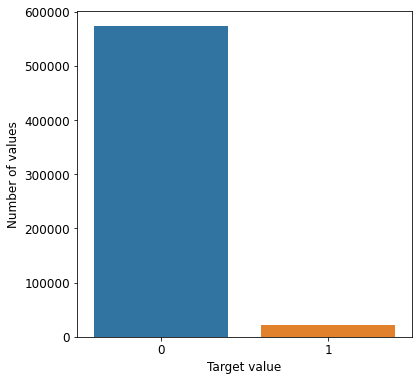

In [13]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Real features

In [14]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [15]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [16]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Car features

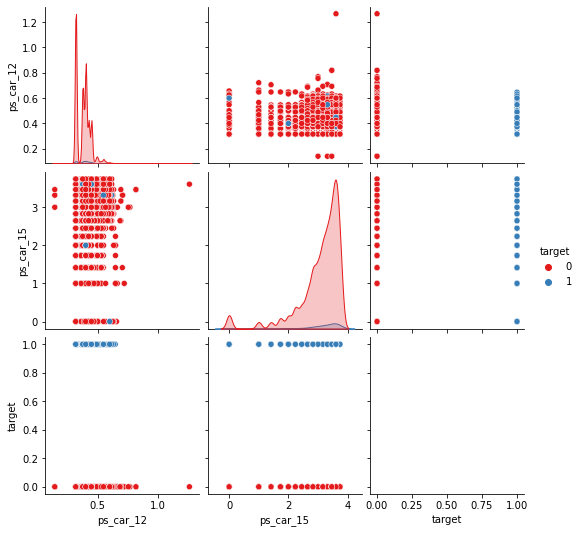

In [22]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
# sample = sample[var]
sns.pairplot(sample, vars=var, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Calculated features

<Figure size 432x288 with 0 Axes>

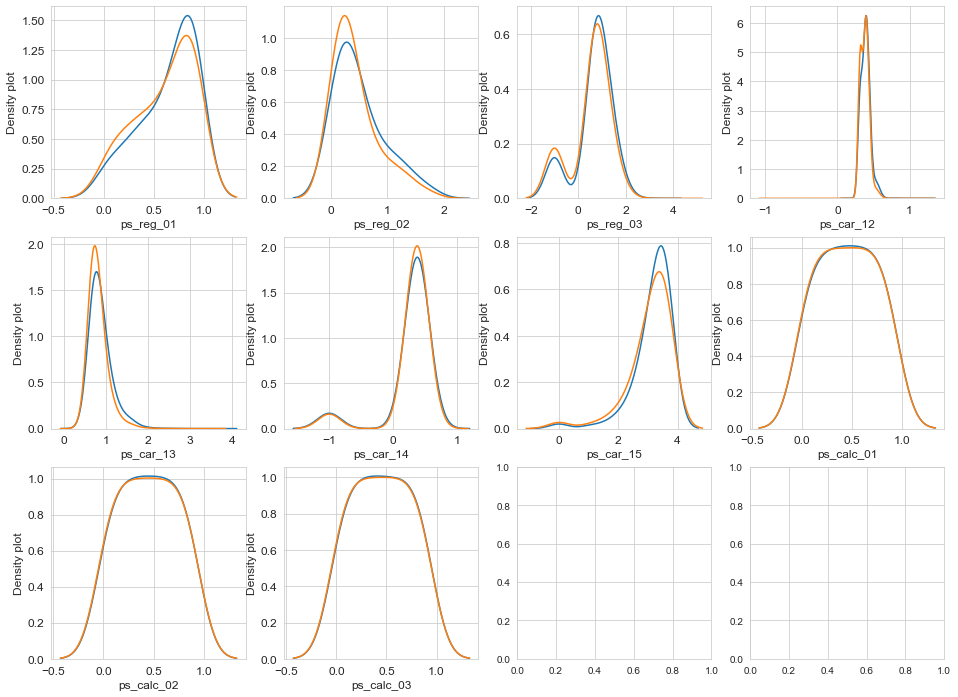

In [27]:
import warnings
warnings.filterwarnings('ignore')

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

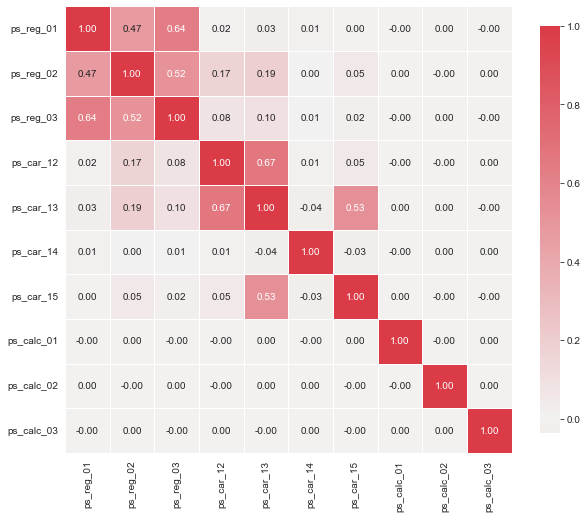

In [28]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', 
               square=True, linewidths=.5, annot=True, cbar_kws={'shrink': .75})
    plt.show()
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

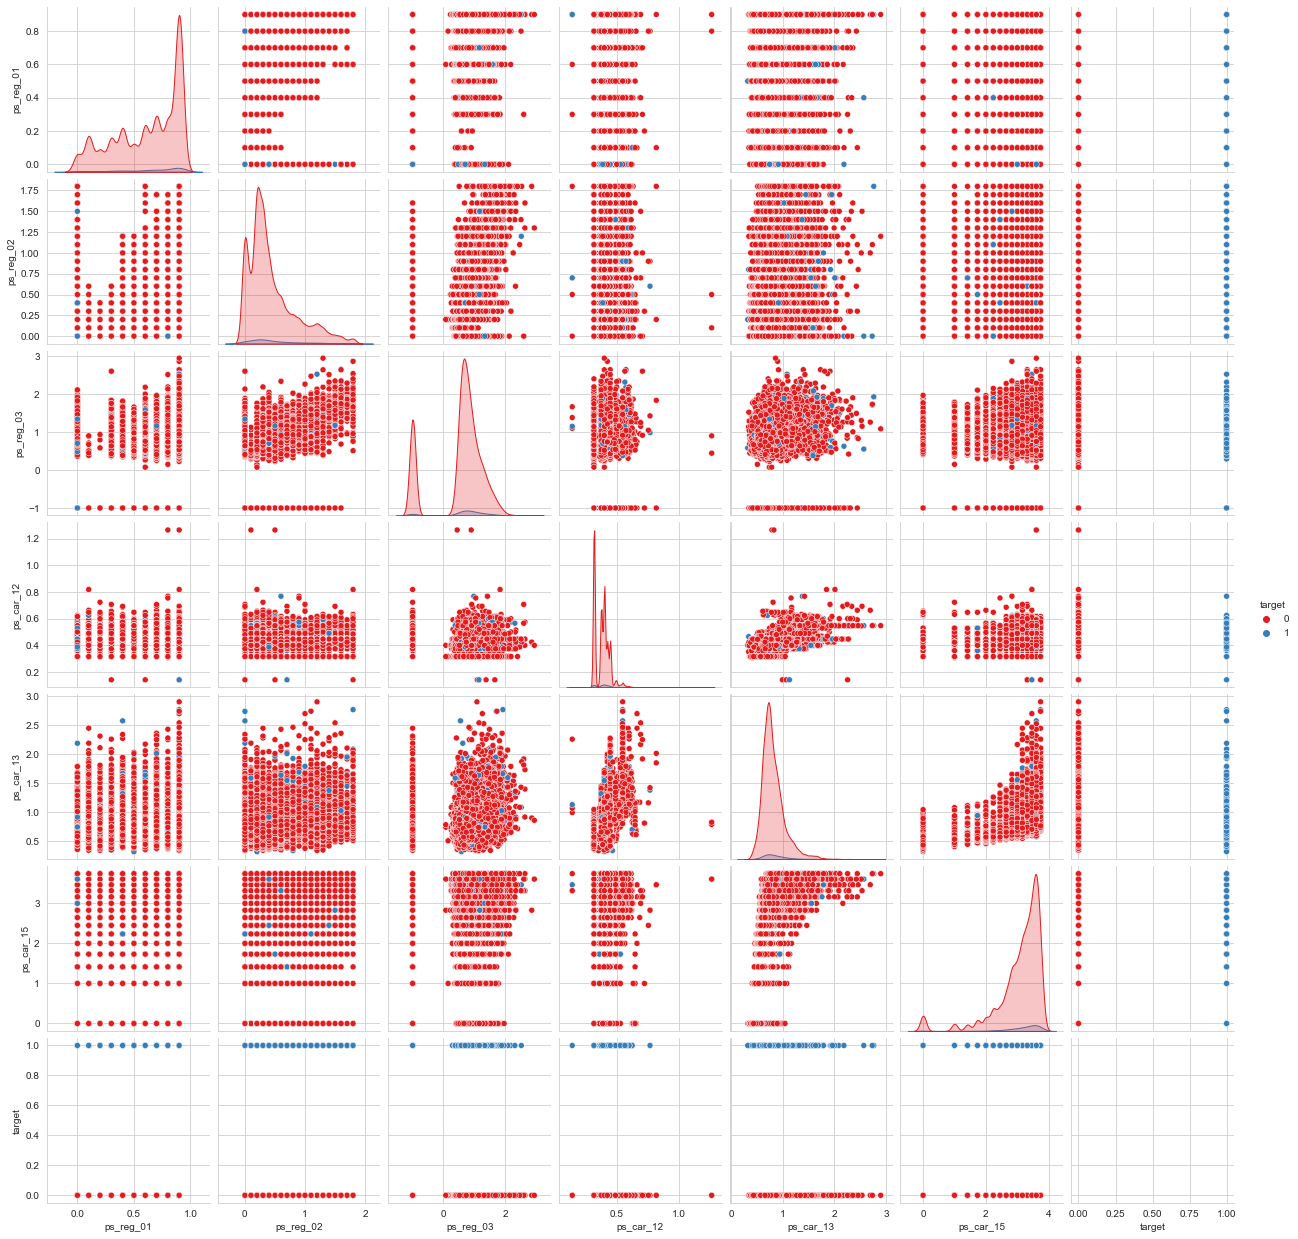

In [29]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 
      'ps_car_15', 'target']
sns.pairplot(sample, vars=var, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Binary features

In [30]:
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

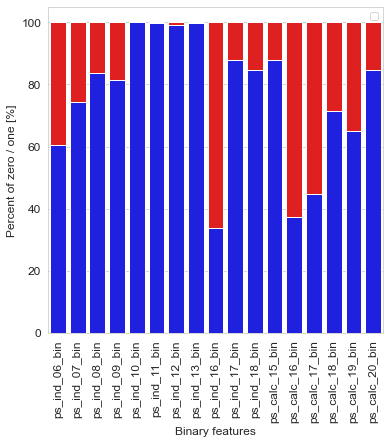

In [32]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col] == 0).sum() / trainset.shape[0] * 100)
    one_list.append((trainset[col] == 1).sum() / trainset.shape[0] * 100)
    
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')
plt.ylabel('Percent of zero / one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'one'))
plt.show()

<Figure size 432x288 with 0 Axes>

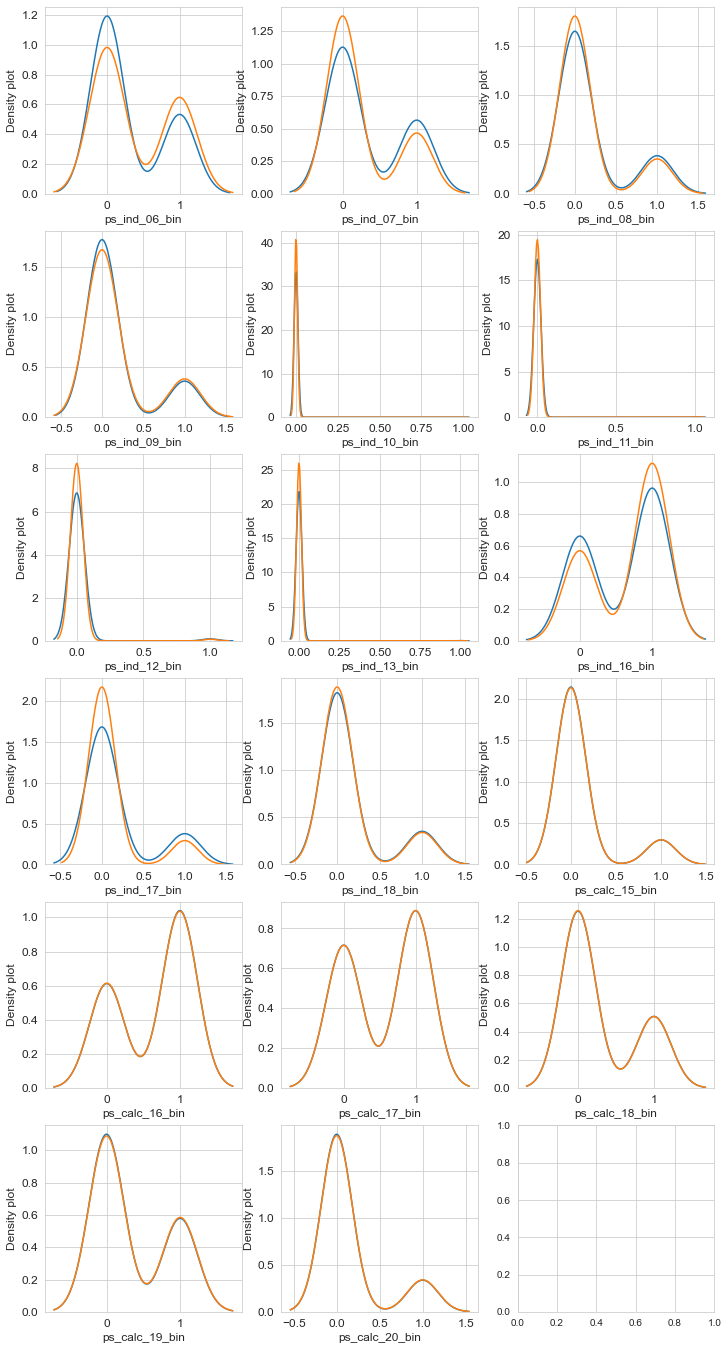

In [33]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Categorical features

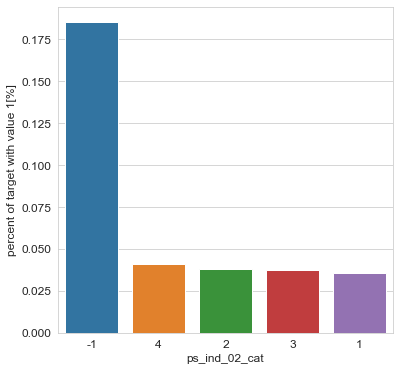

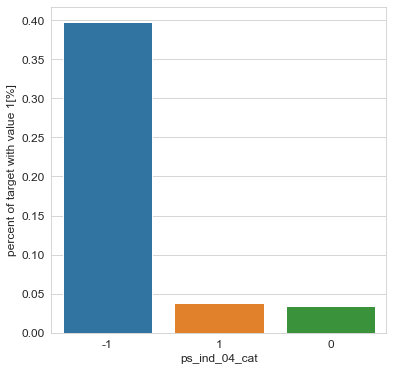

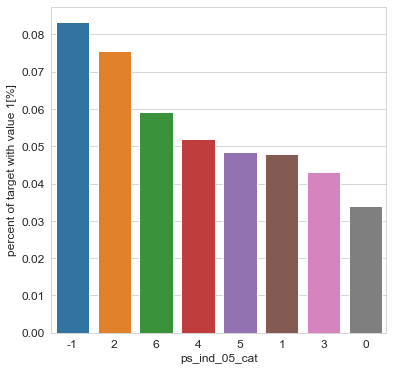

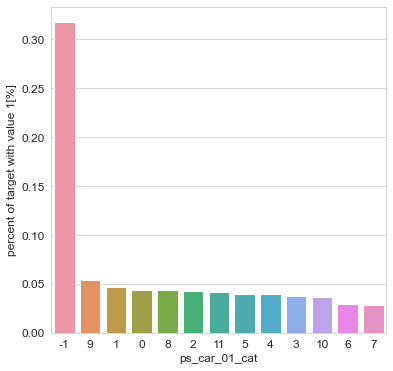

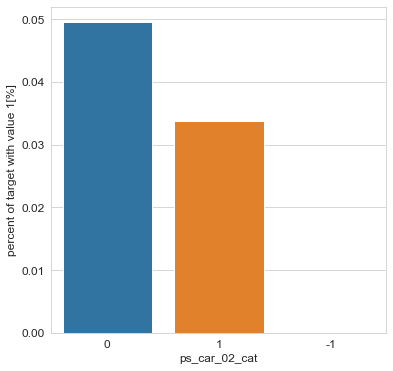

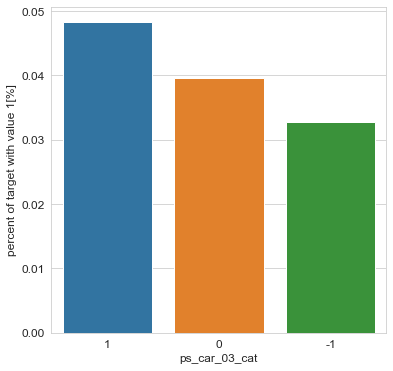

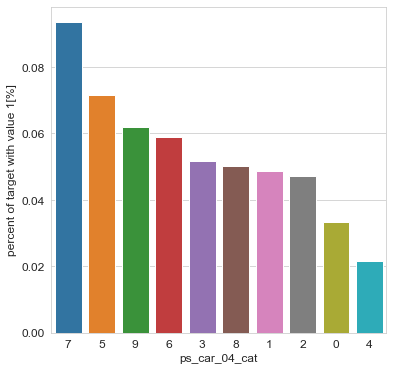

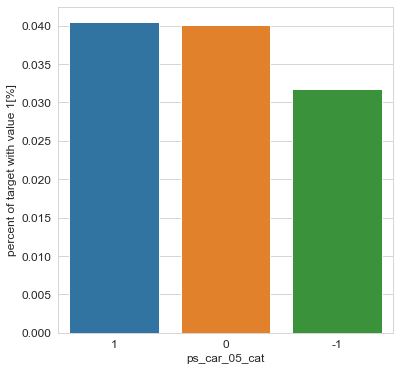

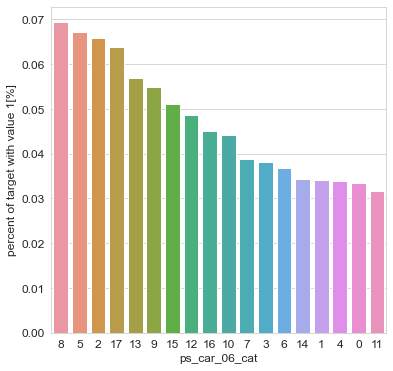

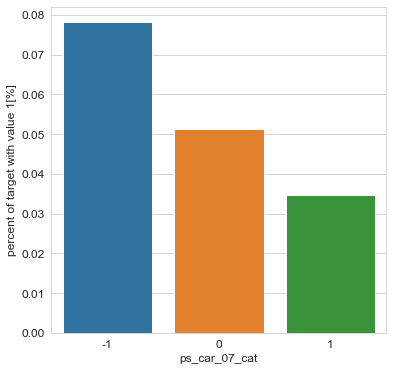

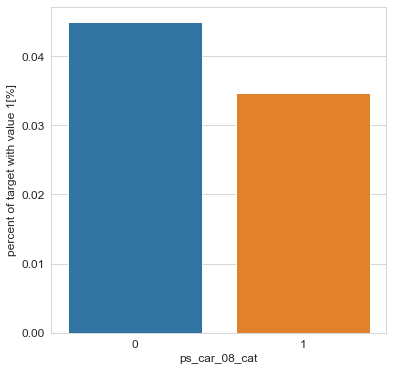

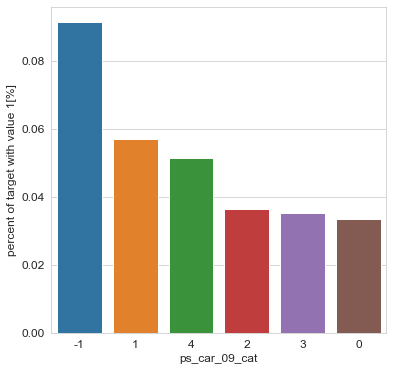

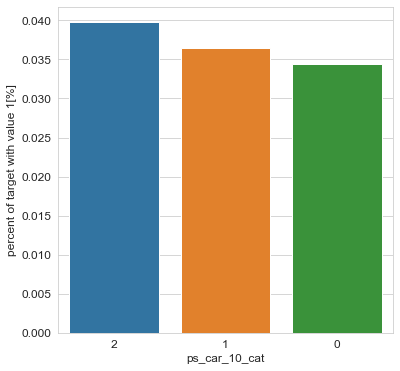

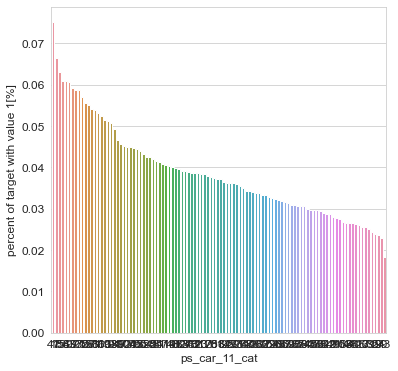

In [34]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    cat_perc = trainset[[feature, 'target']].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    sns.barplot(ax=ax, x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('percent of target with value 1[%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

<Figure size 432x288 with 0 Axes>

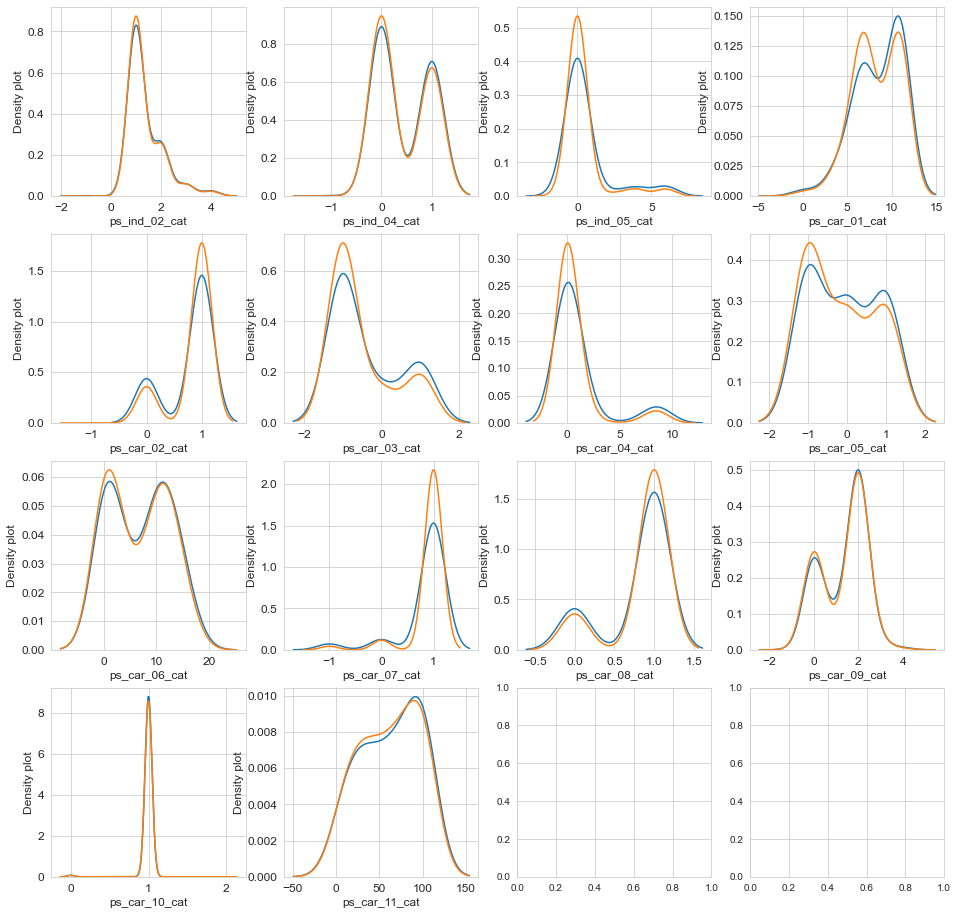

In [35]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Data unbalance between train and test data

<Figure size 432x288 with 0 Axes>

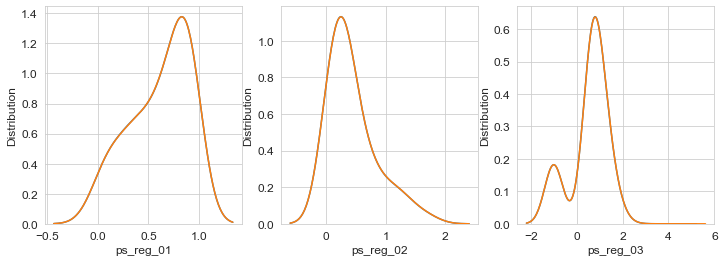

In [37]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

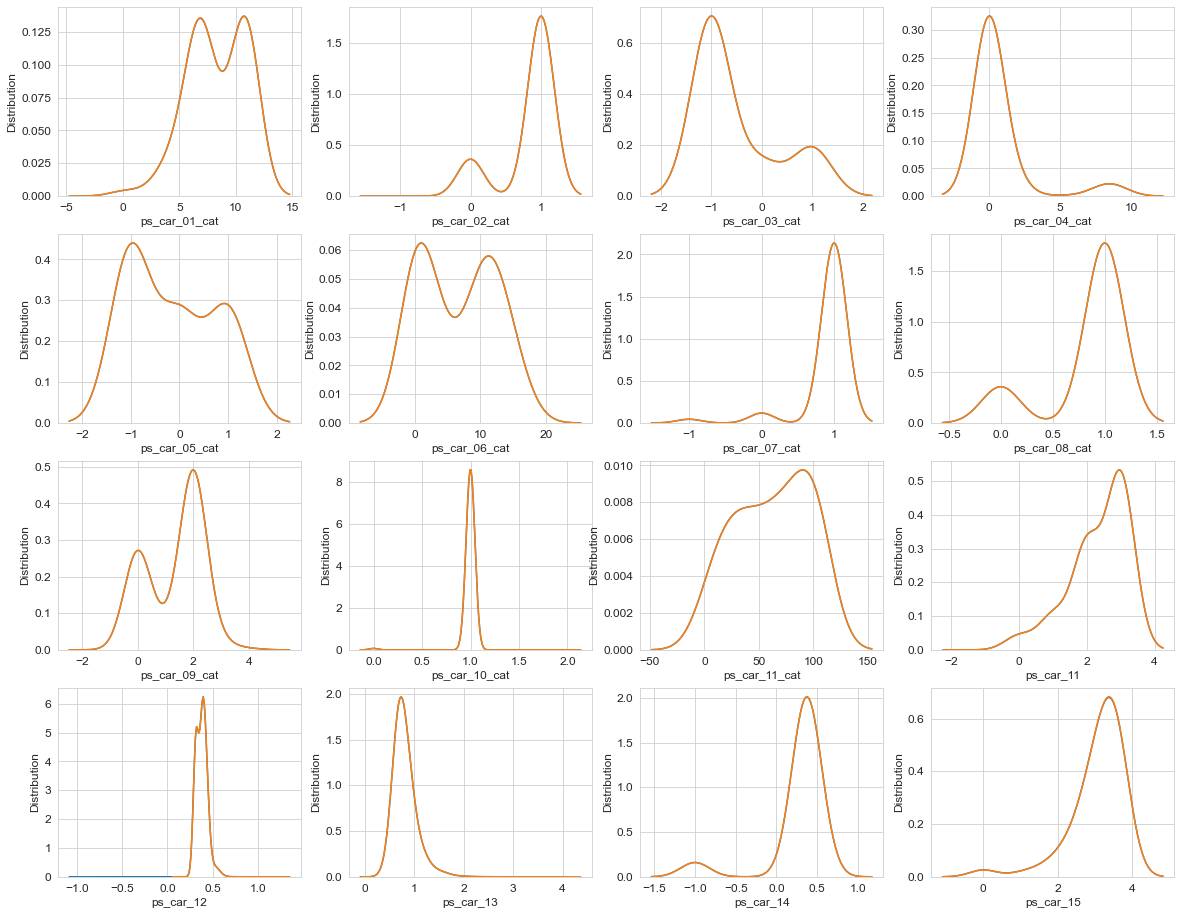

In [39]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

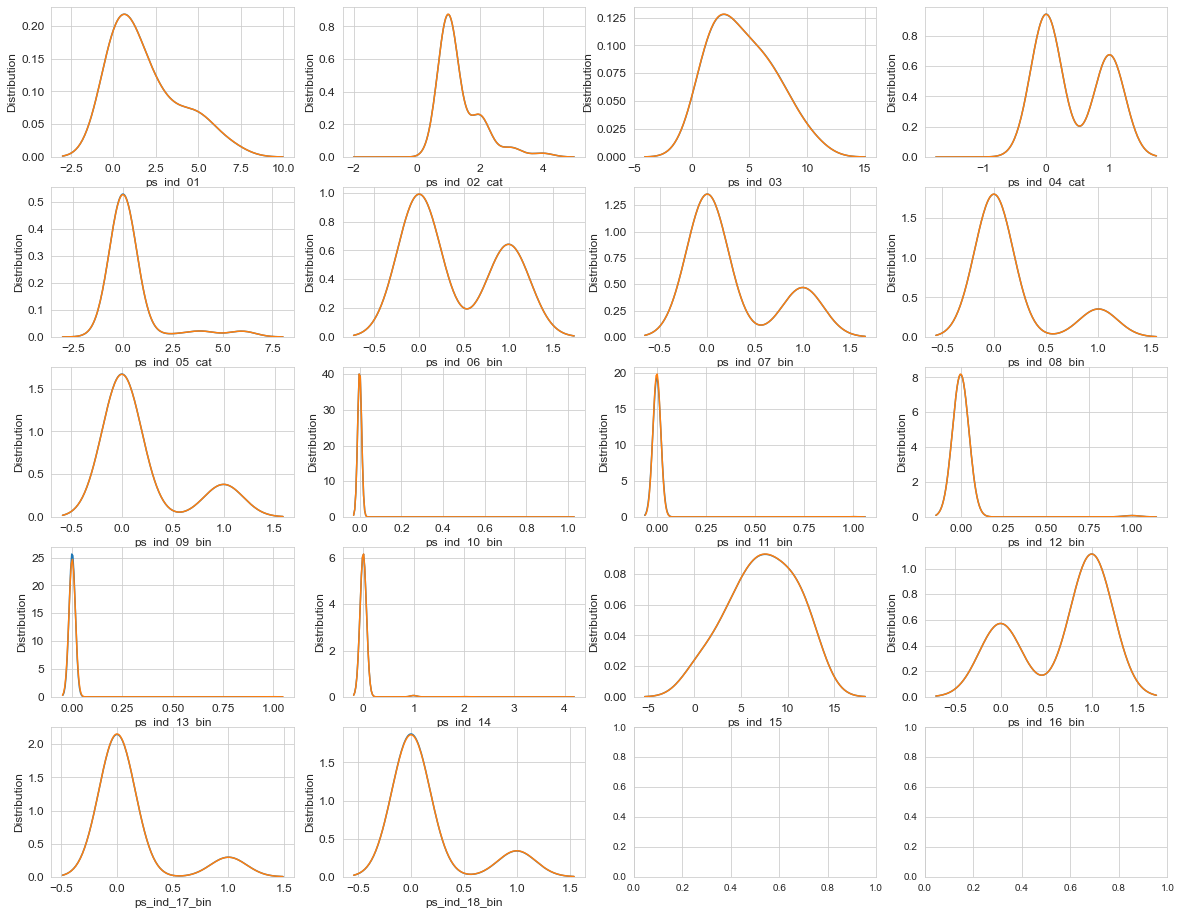

In [41]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

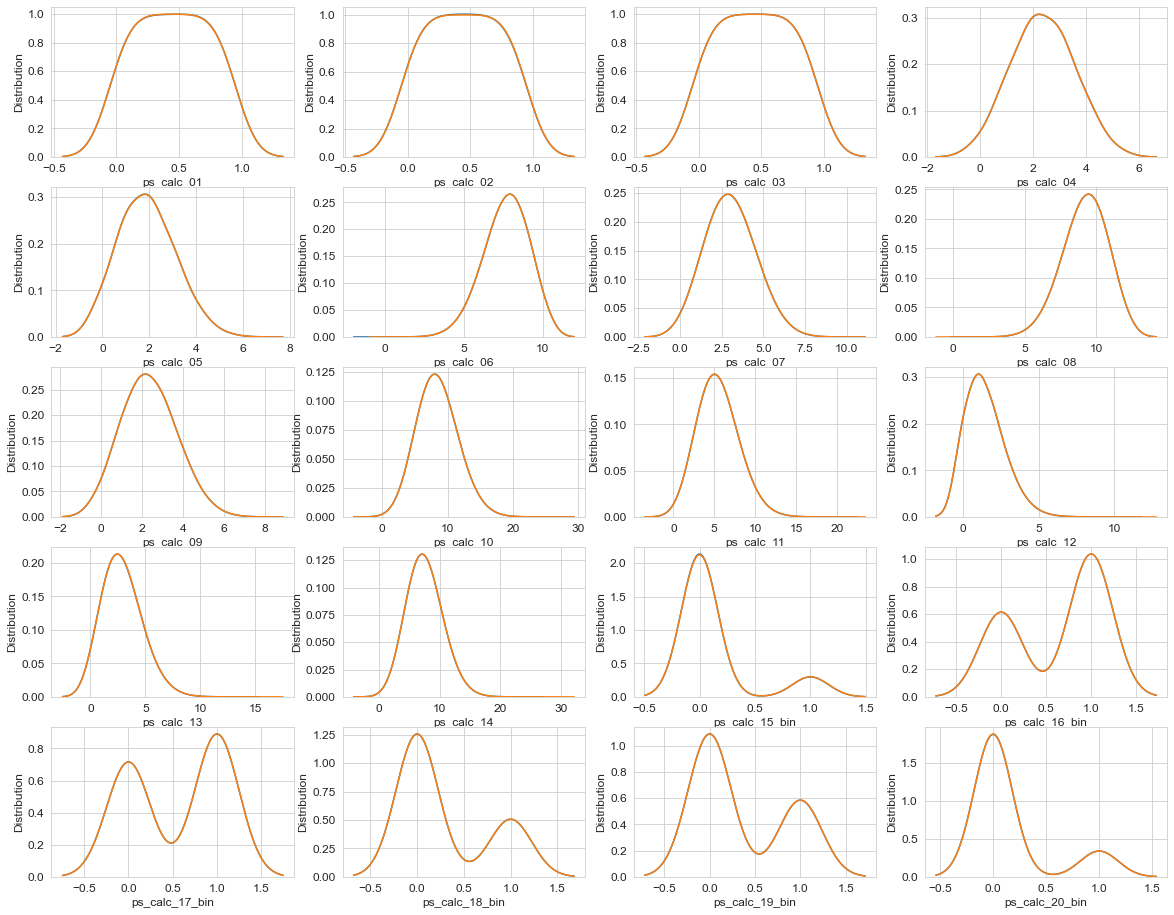

In [42]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label='train')
    sns.kdeplot(testset[feature], bw=0.5, label='test')
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Check data quality

In [43]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings / trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))

print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


## Prepare the data for model

### Drop columns

In [44]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

In [45]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, axis=1, inplace=True)
testset.drop(vars_to_drop, axis=1, inplace=True)

In [46]:
metadata.loc[(vars_to_drop), 'keep'] = False

## target encoding with smoothing

In [47]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, tst_series=None, target=None, 
                 min_samples_leaf=1, smoothing=1, noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean', 'count'])
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    prior = target.mean()
    
    averages[target.name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left'
    )['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_trn_series.index = trn_series.index
    
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left'
    )['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [52]:
trainset['ps_car_11_cat'].unique().shape[0]

104

In [53]:
train_encoded, test_encoded = target_encode(
    trainset['ps_car_11_cat'], testset['ps_car_11_cat'],
    target=trainset.target,
    min_samples_leaf=100,
    smoothing=10,
    noise_level=0.01
)

trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat', 'keep'] = False
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

### Balance target variable (undersampling)

In [54]:
desired_apriori = 0.1

idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

undersampling_rate = ((1 - desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


### Replace -1 values with NaN

In [55]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### Dummify cat values

In [56]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

### Drop unused and target columns

In [57]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target', 'id'], axis=1)
testset = testset.drop(['id'], axis=1)

In [58]:
trainset.shape, testset.shape

((216940, 91), (892816, 91))

## Prepare the model